# Advanced processing

The pynapple package provides a small set of high-level functions that are widely used in system neuroscience.
- [Discrete correlograms](https://peyrachelab.github.io/pynapple/process.correlograms/)
- [Tuning curves](https://peyrachelab.github.io/pynapple/process.tuning_curves/)
- [Decoding](https://peyrachelab.github.io/pynapple/process.decoding/)
- [PETH](https://peyrachelab.github.io/pynapple/process.perievent/)

This notebook provides few examples with artificial data.

In [1]:
import numpy as np
import pandas as pd
import pynapple as nap
import matplotlib.pyplot as plt

## Discrete correlograms

The main function to compute cross-correlogram is [*cross_correlogram*](https://peyrachelab.github.io/pynapple/process.correlograms/#pynapple.process.correlograms.cross_correlogram).


The function is compiled with [numba](https://numba.pydata.org/) to increase performances. This means it accepts only pure numpy array as argument.

Text(0, 0.5, 'CC')

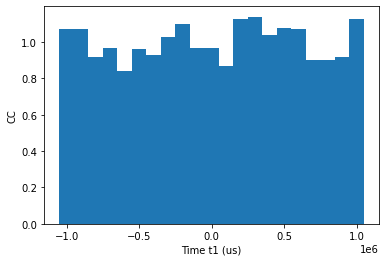

In [2]:
ts1 = nap.Ts(t = np.sort(np.random.uniform(0, 1000, 1000)), time_units = 's')
ts2 = nap.Ts(t = np.sort(np.random.uniform(0, 1000, 1000)), time_units = 's')

ts1_time_array = ts1.as_units('us').index.values
ts2_time_array = ts2.as_units('us').index.values

binsize = 100000 # us
cc12, xt = nap.cross_correlogram(t1 = ts1_time_array,
                                 t2 = ts2_time_array,
                                 binsize=binsize,
                                 windowsize=1000000 # us
                                )

plt.figure()
plt.bar(xt, cc12, binsize)
plt.xlabel("Time t1 (us)")
plt.ylabel("CC")


Since it's a bit tedious to convert to a numpy.ndarray, pynapple provides wrappers for computing autocorrelogram and crosscorrelogram for TsGroup. The function is then called for each unit or each pairs of units. It returns directly a pandas.DataFrame holding all the correlograms. In this example, autocorrelograms and cross-correlograms are computed for the same TsGroup.

In [3]:
epoch = nap.IntervalSet(start = 0, end = 1000, time_units = 's')
ts_group = nap.TsGroup({0:ts1,1:ts2}, time_support = epoch)

autocorrs = nap.compute_autocorrelogram(group=ts_group,                                         
                                        binsize=100, # ms
                                        windowsize=1000, # ms                                        
                                        time_units='ms',
                                        ep=epoch
                                       )
crosscorrs = nap.compute_crosscorrelogram(group=ts_group,                                        
                                        binsize=100, # ms
                                        windowsize=1000, # ms                                        
                                        time_units='ms'
                                       )

print(autocorrs, '\n')
print(crosscorrs, '\n')


         0     1
-1.0  0.99  0.95
-0.9  0.89  1.12
-0.8   1.1  0.95
-0.7  1.12  1.08
-0.6  0.94  0.83
-0.5  0.93  0.97
-0.4  1.05  0.99
-0.3  1.05   1.1
-0.2  0.86  1.16
-0.1  0.95  1.02
 0.0   0.0   0.0
 0.1  0.95  1.02
 0.2  0.86  1.16
 0.3  1.05   1.1
 0.4  1.05  0.99
 0.5  0.93  0.97
 0.6  0.94  0.83
 0.7  1.12  1.08
 0.8   1.1  0.95
 0.9  0.89  1.12
 1.0  0.99  0.95 

         0
         1
-1.0  1.07
-0.9  1.07
-0.8  0.92
-0.7  0.97
-0.6  0.84
-0.5  0.96
-0.4  0.93
-0.3  1.03
-0.2  1.10
-0.1  0.97
 0.0  0.97
 0.1  0.87
 0.2  1.13
 0.3  1.14
 0.4  1.04
 0.5  1.08
 0.6  1.07
 0.7  0.90
 0.8  0.90
 0.9  0.92
 1.0  1.13 



## Peri-Event Time Histogram (PETH)

Another way to look at the spiking relationship with the timing of an event (i.e. stimulus) is to compute a PETH. pynapple provide the function _compute_perievent_ to center spike time around the timestamps of an event within a given window.

In [4]:
stim = nap.Tsd(t = np.sort(np.random.uniform(0, 1000, 10)), 
               d = np.random.rand(10),
               time_units = 's')

peth0 = nap.compute_perievent(ts1, stim, minmax = (-1, 1), time_unit = 's')

print(peth0)

  Index    Freq. (Hz)    ref_times
-------  ------------  -----------
      0           1.5      178.043
      1           0.5      208.763
      2         nan        215.68
      3           1.5      284.683
      4           1.5      470.454
      5           0.5      531.443
      6           1        612.482
      7           1.5      881.25
      8           0.5      951.23
      9           1.5      987.646


/home/guillaume/pynapple/pynapple/core/time_series.py:127: RuntimeWarning: invalid value encountered in double_scalars
  self.rate = len(t)/self.time_support.tot_length('s')


It is then easy to do a raster plot around the times of the stim by calling the _fillna_ function of pandas.

Text(0.5, 0, 'Time from stim (s)')

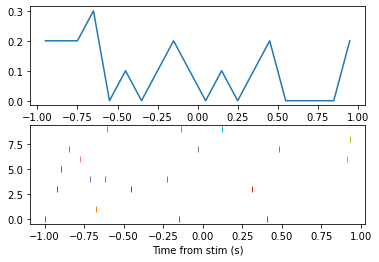

In [5]:
plt.figure()
plt.subplot(211)
plt.plot(peth0.count(0.1, time_units = 's').mean(1))
plt.subplot(212)
for stim_index in peth0.keys():
    plt.plot(peth0[stim_index].as_units('s').fillna(stim_index), '|')
plt.xlabel("Time from stim (s)")

The same function can be applied to a group of neurons.

In [6]:
pethall = nap.compute_perievent(ts_group, stim, minmax = (-1, 1), time_unit = 's')

print(pethall[0])
print(pethall[1])

  Index    Freq. (Hz)    ref_times
-------  ------------  -----------
      0           1.5      178.043
      1           0.5      208.763
      2         nan        215.68
      3           1.5      284.683
      4           1.5      470.454
      5           0.5      531.443
      6           1        612.482
      7           1.5      881.25
      8           0.5      951.23
      9           1.5      987.646
  Index    Freq. (Hz)    ref_times
-------  ------------  -----------
      0           0.5      178.043
      1           1.5      208.763
      2         nan        215.68
      3           1.5      284.683
      4           1.5      470.454
      5         nan        531.443
      6           5        612.482
      7           3        881.25
      8         nan        951.23
      9           0.5      987.646


/home/guillaume/pynapple/pynapple/core/time_series.py:127: RuntimeWarning: invalid value encountered in double_scalars
  self.rate = len(t)/self.time_support.tot_length('s')


## Tuning curves

For now, pynapple can compute 1 dimension tuning curves (for example firing rate as a function of angular direction) and 2 dimension tuning curves ( for example firing rate as a function of position). In both cases, a TsGroup object can be directly passed to the function.

/home/guillaume/pynapple/pynapple/process/tuning_curves.py:140: RuntimeWarning: invalid value encountered in true_divide
  count = count / occupancy


                 a         b
Time (s)                    
0.0       1.000000  0.000000
0.1       0.995004  0.099833
0.2       0.980067  0.198669
0.3       0.955336  0.295520
0.4       0.921061  0.389418
...            ...       ...
999.5     0.889961  0.456036
999.6     0.839987  0.542606
999.7     0.781621  0.623754
999.8     0.715445  0.698670
999.9     0.642120  0.766604

[10000 rows x 2 columns]


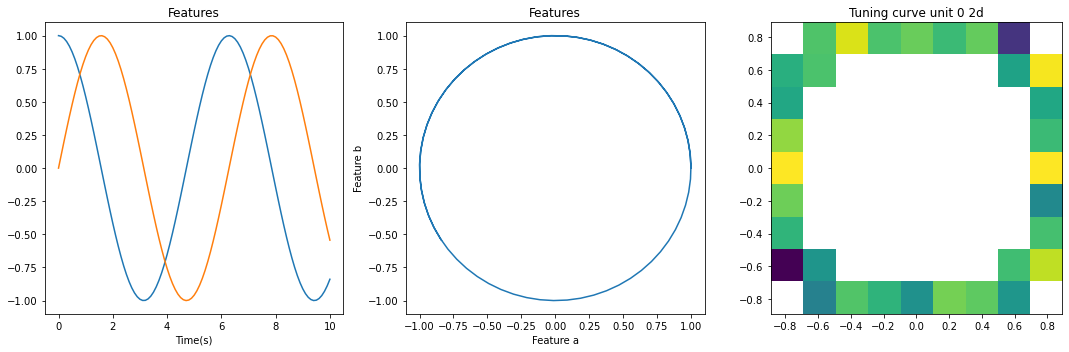

In [7]:
features = np.vstack((np.cos(np.arange(0, 1000, 0.1)),np.sin(np.arange(0,1000,0.1)))).T
features = nap.TsdFrame(t = np.arange(0, 1000, 0.1), d = features, time_units = 's', time_support = epoch, columns=['a', 'b'])

print(features)

tcurves1d = nap.compute_1d_tuning_curves(group=ts_group,
                                         feature=features['a'],
                                         nb_bins=10)

tcurves2d, binsxy = nap.compute_2d_tuning_curves(group=ts_group,
                                                 feature = features,                                                 
                                                 nb_bins=10)

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.plot(features.as_units('s').loc[0:10])
plt.title("Features")
plt.xlabel("Time(s)")
plt.subplot(132)
plt.title("Features")
plt.plot(features['a'].as_units('s').loc[0:10], features['b'].as_units('s').loc[0:10])
plt.xlabel("Feature a")
plt.ylabel("Feature b")
plt.subplot(133)
plt.title("Tuning curve unit 0 2d")
plt.imshow(tcurves2d[0], extent=(binsxy[1][0],binsxy[1][-1],binsxy[0][0],binsxy[0][-1]))
plt.tight_layout()
plt.show()

## Decoding

Pynapple supports 1 dimension and 2 dimension bayesian decoding. The function returns the decoded feature as well as the probabilities for each timestamps.

First let's generate some fake "place fields" in 2 dimensions based on the features.

In [8]:
#############################################################################################
# This part is just to generate units with a relationship to the features (i.e. "place fields")
times = features.index.values
ft = features.values

bounds=np.arange(-1.0, 1.0, 0.5)
ts_group = {}
count = 0
for x in bounds:
    for y in bounds:        
        tidx = times[(ft[:,0]>x) & (ft[:,0]<x+0.5) & (ft[:,1]>y) & (ft[:,1]<y+0.5)]        
        if len(tidx):
            ts_group[count] = nap.Ts(t=np.unique(tidx), time_units='us')
            count += 1
ts_group = nap.TsGroup(ts_group, time_support = epoch)
##############################################################################################

import warnings
warnings.filterwarnings('ignore')

tcurves2d, binsxy = nap.compute_2d_tuning_curves(group=ts_group,
                                                 feature=features,                                                 
                                                 nb_bins=8,
                                                 ep=epoch)

Let's plot the "place fields".

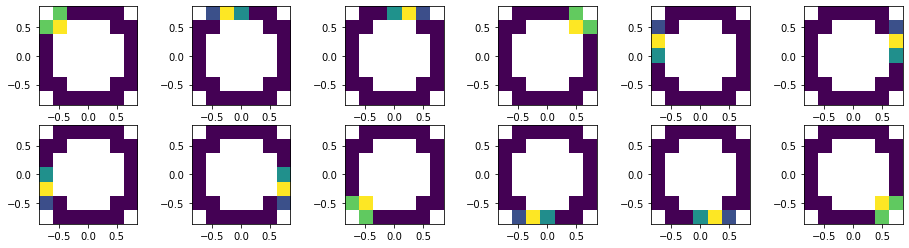

In [9]:
plt.figure(figsize = (16,4))
for i in ts_group.keys():
    plt.subplot(2,6,i+1)
    plt.imshow(tcurves2d[i], extent=(binsxy[1][0],binsxy[1][-1],binsxy[0][0],binsxy[0][-1]))
    plt.xticks()
plt.show()

Then we can call the actual decoding function in 2d.

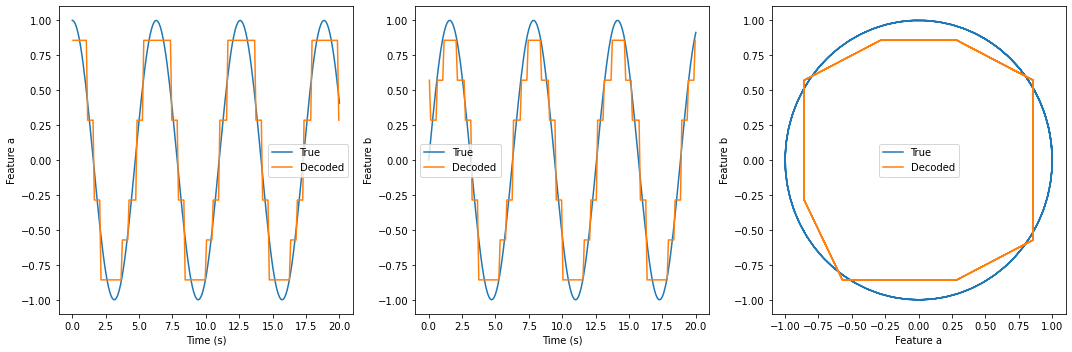

In [10]:
decoded, proba_feature = nap.decode_2d(tuning_curves=tcurves2d, 
                                     group=ts_group,                                   
                                     ep=epoch,
                                     bin_size=0.1, # second
                                     xy=binsxy,
                                    features=features,
                                    )


plt.figure(figsize=(15,5))
plt.subplot(131)
plt.plot(features['a'].as_units('s').loc[0:20], label = 'True')
plt.plot(decoded['a'].as_units('s').loc[0:20], label = 'Decoded')
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Feature a")
plt.subplot(132)
plt.plot(features['b'].as_units('s').loc[0:20], label = 'True')
plt.plot(decoded['b'].as_units('s').loc[0:20], label = 'Decoded')
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Feature b")
plt.subplot(133)
plt.plot(features['a'].as_units('s').loc[0:20], features['b'].as_units('s').loc[0:20], label = 'True')
plt.plot(decoded['a'].as_units('s').loc[0:20], decoded['b'].as_units('s').loc[0:20], label = 'Decoded')
plt.xlabel("Feature a")
plt.ylabel("Feature b")
plt.legend()
plt.tight_layout()
plt.show()